<a href="https://colab.research.google.com/github/MouseLand/cellpose/blob/main/notebooks/run_cellpose_2.0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Running cellpose 2.0 in colab with a GPU

<font size = 4>Cellpose 2.0 now allows you to train your own models in the GUI!

This notebook allows you to load this **custom model** and run the model on your images with a GPU. 

In this notebook, you can also **train** a custom model using your labels (`_seg.npy`) files, or other labels as `_masks.tif` files. If you already have a trained model, skip this part of the notebook.

For more details on cellpose 2.0 check out the [paper](https://www.biorxiv.org/content/10.1101/2022.04.01.486764v1) or the [talk](https://www.youtube.com/watch?v=3ydtAhfq6H0).

Mount your google drive to access all your image files, segmentations, and custom models. This also ensures that any models you train are saved to your google drive. If you'd like to try out the notebook without your own files, please download the sample images from tissuenet (optional step in Setup below).

This notebook was inspired by the Zero-Cost Deep-Learning to Enhance Microscopy project (https://github.com/HenriquesLab/DeepLearning_Collab/wiki). Jointly developed by the Jacquemet (link to https://cellmig.org/) and Henriques (https://henriqueslab.github.io/) laboratories. Please check out their great work!

# Setup

We will first install cellpose 2.0, check the GPU is working, and mount google drive to get your models and images.

## Installation

Install cellpose -- by default the torch GPU version is installed in COLAB notebook.

In [1]:
!pip install "opencv-python-headless<4.3"
!pip install cellpose

Check CUDA version and that GPU is working in cellpose and import other libraries.

In [10]:
!nvcc --version
!nvidia-smi

import os, shutil
import numpy as np
import matplotlib.pyplot as plt
from cellpose import core, utils, io, models, metrics
from glob import glob

use_GPU = core.use_gpu()
yn = ['NO', 'YES']
print(f'>>> GPU activated? {yn[use_GPU]}')

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Fri_Jan__6_16:45:21_PST_2023
Cuda compilation tools, release 12.0, V12.0.140
Build cuda_12.0.r12.0/compiler.32267302_0
Thu Jun 20 22:45:33 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.171.04             Driver Version: 535.171.04   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:01:00.0  On |                  Off |
|  0%   52C    P5              38W / 45

### Download sample images (optional)

If you don't mount your google drive, and want to test cellpose 2.0, run the next code block to download the example data. This `human_in_the_loop` folder has a `train` folder with training images and manual segmentations (in this case created in the loop), and a `test` folder with test images and manual segmentations from scratch.

These images are from the breast vectra class from the Tissuenet dataset. The full Tissuenet dataset is available [here](https://datasets.deepcell.org/), and for a description of the data see the [paper](https://www.nature.com/articles/s41587-021-01094-0).

We will convert the `_seg.npy` files to `_masks.tif` files.

In [11]:
from natsort import natsorted
#url = 'https://drive.google.com/uc?id=1HXpLczf7TPCdI1yZY5KV3EkdWzRrgvhQ'
#utils.download_url_to_file(url, 'human_in_the_loop.zip')

#!unzip human_in_the_loop
train_files = natsorted(glob('augmented/train/*.tif'))
train_seg = natsorted(glob('augmented/train/*.npy'))

test_files = natsorted(glob('augmented/test/*.npy'))
test_seg = natsorted(glob('augmented/test/*.npy'))


what the training images look like + their labels

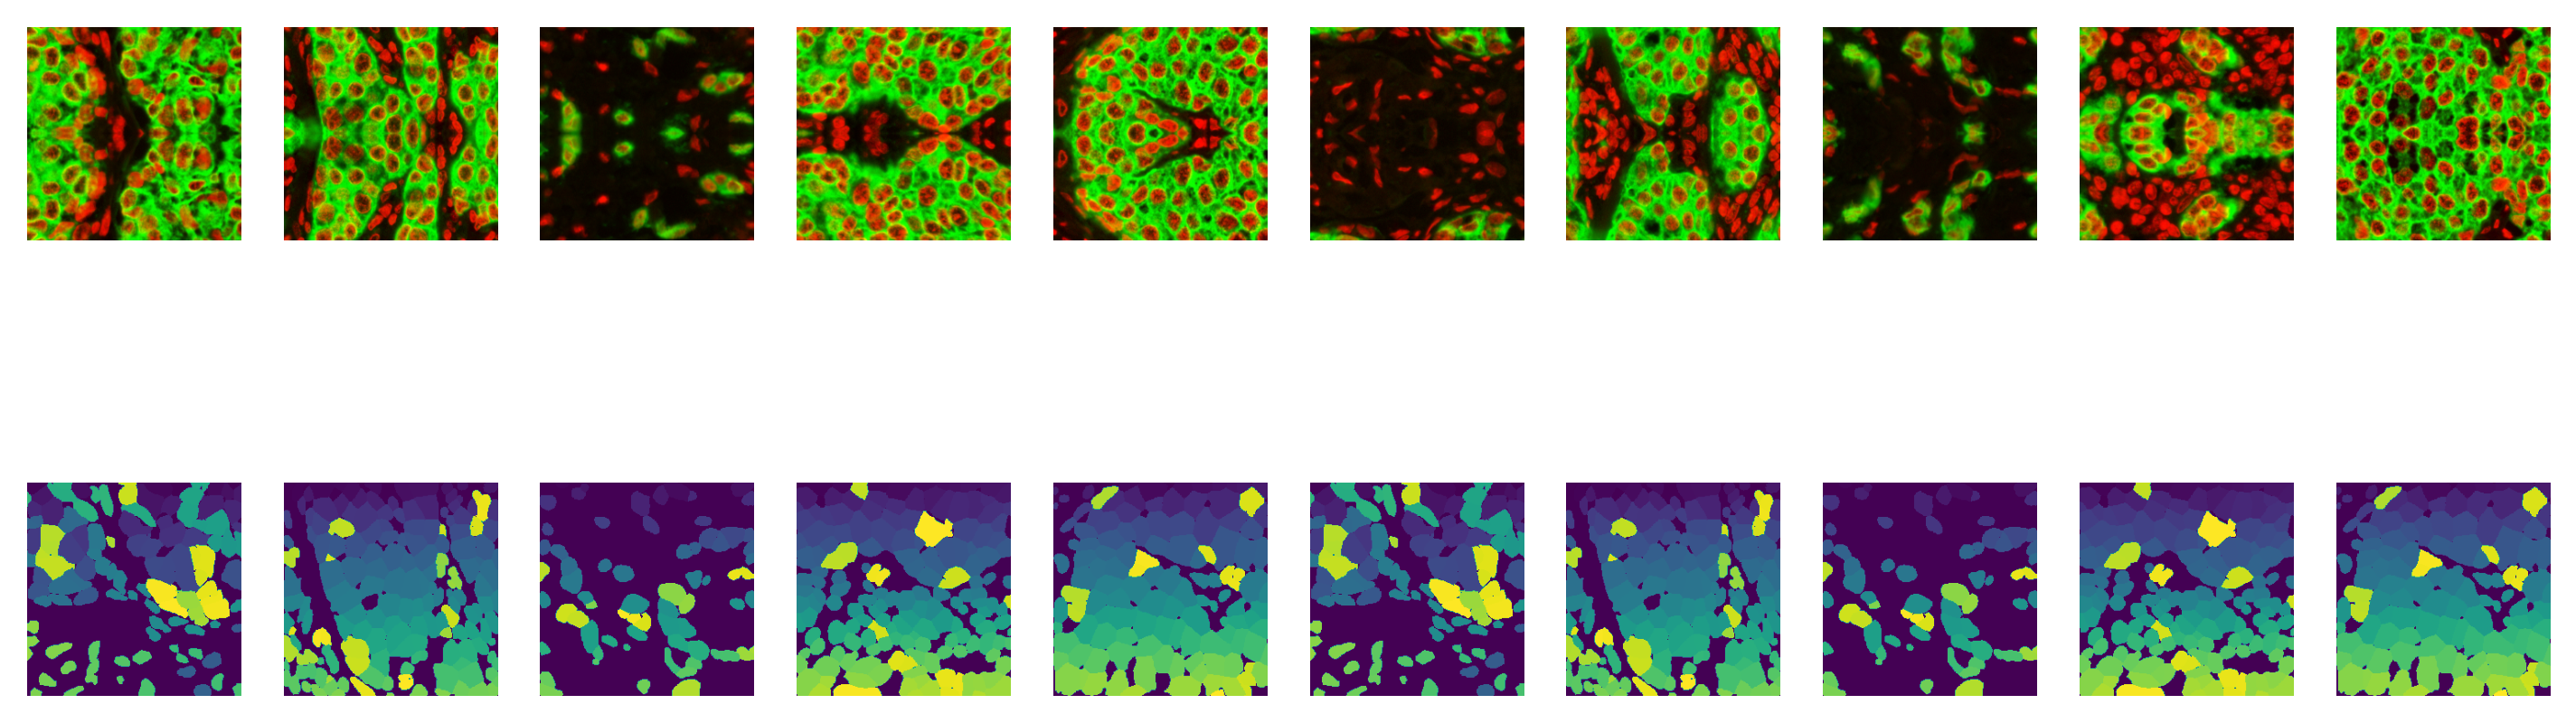

In [12]:
plt.figure(figsize=(12,4), dpi=300)
for k,f in enumerate(train_files):
    img = io.imread(f)
    plt.subplot(2,len(train_files),k+1)
    img = np.vstack((img, np.zeros_like(img)[:1]))
    img = img.transpose(1,2,0)
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(2,len(train_files),len(train_files) + k+1)
    seg = np.load(os.path.splitext(f)[0] + '_seg.npy', allow_pickle=True).item()
    masks= seg['masks'].squeeze()
    plt.imshow(masks)
    plt.axis('off')


# Train model on manual annotations

Skip this step if you already have a pretrained model.

Fill out the form below with the paths to your data and the parameters to start training.

## Training parameters

<font size = 4> **Paths for training, predictions and results**


<font size = 4>**`train_dir:`, `test_dir`:** These are the paths to your folders train_dir (with images and masks of training images) and test_dir (with images and masks of test images). You can leave the test_dir blank, but it's recommended to have some test images to check the model's performance. To find the paths of the folders containing the respective datasets, go to your Files on the left of the notebook, navigate to the folder containing your files and copy the path by right-clicking on the folder, **Copy path** and pasting it into the right box below.

<font size = 4>**`initial_model`:** Choose a model from the cellpose [model zoo](https://cellpose.readthedocs.io/en/latest/models.html#model-zoo) to start from.

<font size = 4>**`model_name`**: Enter the path where your model will be saved once trained (for instance your result folder).

<font size = 4>**Training parameters**

<font size = 4>**`number_of_epochs`:** Input how many epochs (rounds) the network will be trained. At least 100 epochs are recommended, but sometimes 250 epochs are necessary, particularly from scratch. **Default value: 100**



In [19]:
train_dir = "augmented/train" 
test_dir = "augmented/test" 
#Define where the patch file will be saved
base = "/content"

# model name and path
from cellpose import models
initial_model = "cyto3" #["cyto", "cyto3","nuclei","tissuenet_cp3", "livecell_cp3", "yeast_PhC_cp3", "yeast_BF_cp3", "bact_phase_cp3", "bact_fluor_cp3", "deepbacs_cp3", "scratch"]
model_name = "CP_tissuenet" 

# other parameters for training.
n_epochs = 10

Channel_to_use_for_training = "Green" # ["Grayscale", "Blue", "Green", "Red"]

# If you have a secondary channel that can be used for training, for instance nuclei, choose it here:

Second_training_channel= "Red" #@param ["None", "Blue", "Green", "Red"]


# Advanced Parameters

Use_Default_Advanced_Parameters = True 
##If not, please input:
learning_rate = 0.1 
weight_decay = 0.0001

if (Use_Default_Advanced_Parameters): 
  print("Default advanced parameters enabled")
  learning_rate = 0.1 
  weight_decay = 0.0001
  
#here we check that no model with the same name already exist, if so delete
model_path = train_dir + 'models/'
if os.path.exists(model_path+'/'+model_name):
  print("!! WARNING: "+model_name+" already exists and will be deleted in the following cell !!")
  
if len(test_dir) == 0:
  test_dir = None

# Here we match the channel to number
if Channel_to_use_for_training == "Grayscale":
  chan = 0
elif Channel_to_use_for_training == "Blue":
  chan = 3
elif Channel_to_use_for_training == "Green":
  chan = 2
elif Channel_to_use_for_training == "Red":
  chan = 1


if Second_training_channel == "Blue":
  chan2 = 3
elif Second_training_channel == "Green":
  chan2 = 2
elif Second_training_channel == "Red":
  chan2 = 1
elif Second_training_channel == "None":
  chan2 = 0

if initial_model=='scratch':
  initial_model = 'None'

Default advanced parameters enabled


## Train new model

Using settings from form above, train model in notebook.

In [20]:
from cellpose import train 

# start logger (to see training across epochs)
logger = io.logger_setup()

# DEFINE CELLPOSE MODEL (without size model)
model = models.CellposeModel(gpu=use_GPU, model_type=initial_model)

# set channels
channels = [chan, chan2]

# get files
output = io.load_train_test_data(train_dir, test_dir, mask_filter='_seg.npy')
train_data, train_labels, _, test_data, test_labels, _ = output

new_model_path = train.train_seg(model.net, train_data=train_data, 
                              train_labels=train_labels, 
                              test_data=test_data,
                              test_labels=test_labels,
                              channels=channels, 
                              save_path=train_dir, 
                              n_epochs=n_epochs,
                              learning_rate=learning_rate, 
                              weight_decay=weight_decay, 
                              SGD=True,
                              nimg_per_epoch=8,
                              model_name=model_name)

# diameter of labels in training images
diam_labels = model.net.diam_labels.item()

2024-06-20 22:48:13,005 [INFO] WRITING LOG OUTPUT TO /home/sam/.cellpose/run.log
2024-06-20 22:48:13,005 [INFO] 
cellpose version: 	3.0.7 
platform:       	linux 
python version: 	3.10.13 
torch version:  	2.2.0+cu121
2024-06-20 22:48:13,006 [INFO] >> cyto3 << model set to be used
2024-06-20 22:48:13,006 [INFO] ** TORCH CUDA version installed and working. **
2024-06-20 22:48:13,006 [INFO] >>>> using GPU
2024-06-20 22:48:13,071 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2024-06-20 22:48:13,073 [INFO] not all flows are present, running flow generation for all images
2024-06-20 22:48:13,082 [INFO] 10 / 10 images in augmented/train folder have labels
2024-06-20 22:48:13,083 [INFO] not all flows are present, running flow generation for all images
2024-06-20 22:48:13,091 [INFO] 6 / 6 images in augmented/test folder have labels
2024-06-20 22:48:13,091 [INFO] computing flows for labels


100%|██████████| 10/10 [00:00<00:00, 98.01it/s]

2024-06-20 22:48:13,196 [INFO] computing flows for labels



100%|██████████| 6/6 [00:00<00:00, 111.67it/s]

2024-06-20 22:48:13,253 [INFO] >>> computing diameters



100%|██████████| 6/6 [00:00<00:00, 7589.21it/s]

2024-06-20 22:48:13,256 [INFO] >>> using channels [2, 1]
2024-06-20 22:48:13,256 [INFO] >>> normalizing {'lowhigh': None, 'percentile': None, 'normalize': True, 'norm3D': False, 'sharpen_radius': 0, 'smooth_radius': 0, 'tile_norm_blocksize': 0, 'tile_norm_smooth3D': 1, 'invert': False}
2024-06-20 22:48:13,281 [INFO] >>> n_epochs=10, n_train=10, n_test=6
2024-06-20 22:48:13,282 [INFO] >>> SGD, learning_rate=0.10000, weight_decay=0.00010, momentum=0.900
2024-06-20 22:48:13,282 [INFO] >>> saving model to augmented/train/models/CP_tissuenet


2024-06-20 22:48:13,359 [INFO] 0, train_loss=8.2380, test_loss=6.3030, LR=0.0000, time 0.08s
2024-06-20 22:48:13,667 [INFO] 5, train_loss=6.1753, test_loss=4.5068, LR=0.0556, time 0.38s


## Evaluate on test data (optional)

If you have test data, check performance

In [21]:
# get files (during training, test_data is transformed so we will load it again)
output = io.load_train_test_data(test_dir, mask_filter='_seg.npy')
test_data, test_labels = output[:2]

# run model on test images
masks = model.eval(test_data, 
                   channels=[chan, chan2],
                   diameter=diam_labels)[0]

# check performance using ground truth labels
ap = metrics.average_precision(test_labels, masks)[0]
print('')
print(f'>>> average precision at iou threshold 0.5 = {ap[:,0].mean():.3f}')


2024-06-20 22:48:18,547 [INFO] not all flows are present, running flow generation for all images
2024-06-20 22:48:18,555 [INFO] 6 / 6 images in augmented/test folder have labels
2024-06-20 22:48:19,751 [INFO] 100%|##########| 6/6 [00:01<00:00,  5.02it/s]

>>> average precision at iou threshold 0.5 = 0.000


plot masks

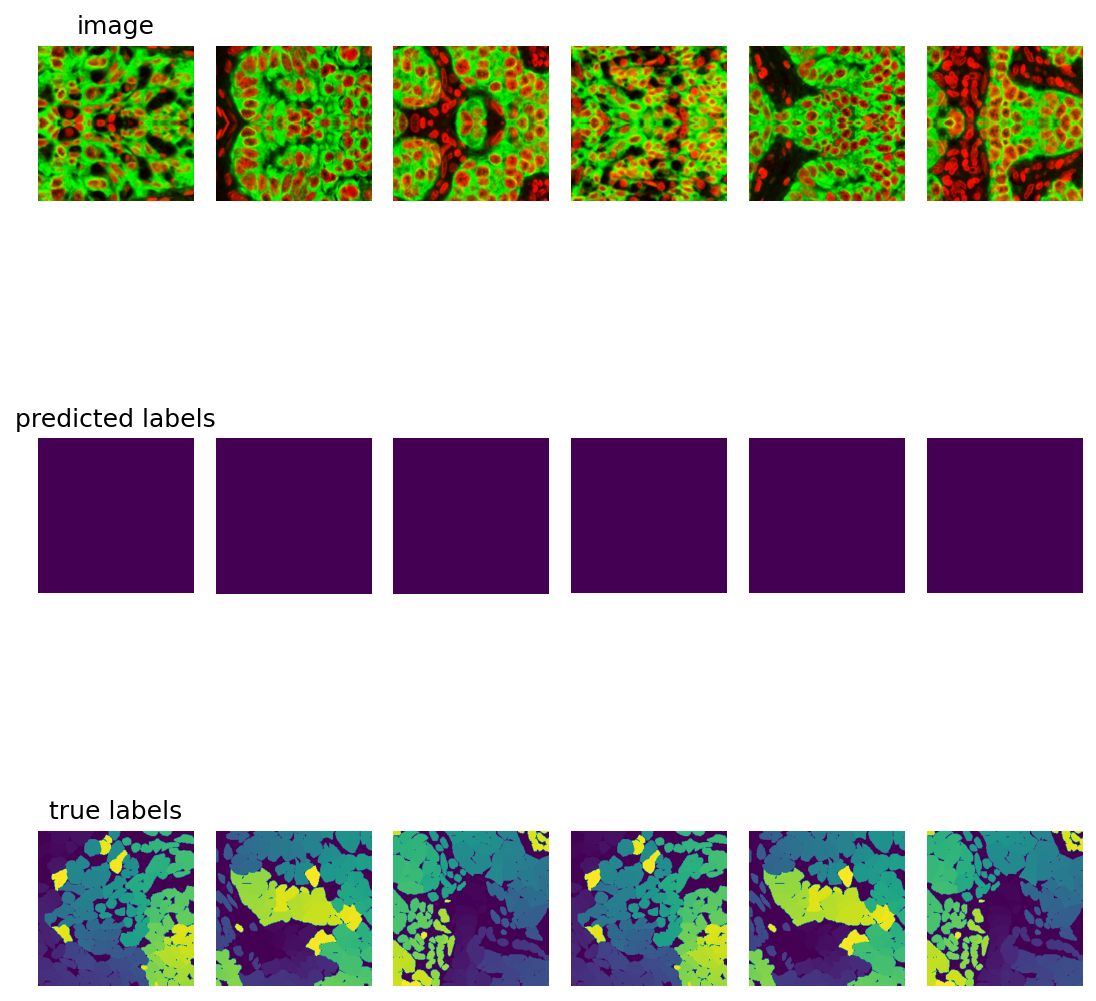

In [22]:

plt.figure(figsize=(12,8), dpi=150)
for k,im in enumerate(test_data):
    img = im.copy()
    plt.subplot(3,len(train_files), k+1)
    img = np.vstack((img, np.zeros_like(img)[:1]))
    img = img.transpose(1,2,0)
    plt.imshow(img)
    plt.axis('off')
    if k==0:
        plt.title('image')

    plt.subplot(3,len(train_files), len(train_files) + k+1)
    plt.imshow(masks[k])
    plt.axis('off')
    if k==0:
        plt.title('predicted labels')

    plt.subplot(3,len(train_files), 2*len(train_files) + k+1)
    plt.imshow(test_labels[k])
    plt.axis('off')
    if k==0:
        plt.title('true labels')
plt.tight_layout()

# Use custom model to segment images

Take custom trained model from above, or upload your own model to google drive / colab runtime.

## Parameters

In [56]:
# model name and path

#@markdown ###Custom model path (full path):

model_path = "human_in_the_loop/train/models/CP_tissuenet" #@param {type:"string"}

#@markdown ###Path to images:

dir = "augmented/test" #@param {type:"string"}

#@markdown ###Channel Parameters:

Channel_to_use_for_segmentation = "Green" #@param ["Grayscale", "Blue", "Green", "Red"]

# @markdown If you have a secondary channel that can be used, for instance nuclei, choose it here:

Second_segmentation_channel= "Red" #@param ["None", "Blue", "Green", "Red"]


# Here we match the channel to number
if Channel_to_use_for_segmentation == "Grayscale":
  chan = 0
elif Channel_to_use_for_segmentation == "Blue":
  chan = 3
elif Channel_to_use_for_segmentation == "Green":
  chan = 2
elif Channel_to_use_for_segmentation == "Red":
  chan = 1


if Second_segmentation_channel == "Blue":
  chan2 = 3
elif Second_segmentation_channel == "Green":
  chan2 = 2
elif Second_segmentation_channel == "Red":
  chan2 = 1
elif Second_segmentation_channel == "None":
  chan2 = 0

#@markdown ### Segmentation parameters:

#@markdown diameter of cells (set to zero to use diameter from training set):
diameter =  0#@param {type:"number"}
#@markdown threshold on flow error to accept a mask (set higher to get more cells, e.g. in range from (0.1, 3.0), OR set to 0.0 to turn off so no cells discarded):
flow_threshold = 0.4 #@param {type:"slider", min:0.0, max:3.0, step:0.1}
#@markdown threshold on cellprob output to seed cell masks (set lower to include more pixels or higher to include fewer, e.g. in range from (-6, 6)):
cellprob_threshold=0 #@param {type:"slider", min:-6, max:6, step:1}


if you're using the example test data we'll copy it to a new folder

In [57]:
src = 'augmented/test'
if dir[:len(src)] == src:
    files = io.get_image_files(dir, '_masks')
    dir = 'augmented/eval/'
    os.makedirs(dir, exist_ok=True)
    for f in files:
        dst = dir + os.path.split(f)[1]
        print(f'{f} > {dst}')
        shutil.copyfile(f, dst)

augmented/test/left_mirrored_breast_vectra_0.tif > augmented/eval/left_mirrored_breast_vectra_0.tif
augmented/test/left_mirrored_breast_vectra_0_outlines.png > augmented/eval/left_mirrored_breast_vectra_0_outlines.png
augmented/test/left_mirrored_img_1213.tif > augmented/eval/left_mirrored_img_1213.tif
augmented/test/left_mirrored_img_1213_outlines.png > augmented/eval/left_mirrored_img_1213_outlines.png
augmented/test/left_mirrored_img_1220.tif > augmented/eval/left_mirrored_img_1220.tif
augmented/test/left_mirrored_img_1220_outlines.png > augmented/eval/left_mirrored_img_1220_outlines.png
augmented/test/right_mirrored_breast_vectra_0.tif > augmented/eval/right_mirrored_breast_vectra_0.tif
augmented/test/right_mirrored_breast_vectra_0_outlines.png > augmented/eval/right_mirrored_breast_vectra_0_outlines.png
augmented/test/right_mirrored_img_1213.tif > augmented/eval/right_mirrored_img_1213.tif
augmented/test/right_mirrored_img_1213_outlines.png > augmented/eval/right_mirrored_img_1213

## run custom model

how to run the custom model in a notebook

In [58]:
# gets image files in dir (ignoring image files ending in _masks)
files = io.get_image_files(dir, '_masks')
print(files)
images = [io.imread(f) for f in files]

# declare model
model = models.CellposeModel(gpu=True, 
                             pretrained_model=model_path)

# use model diameter if user diameter is 0
diameter = model.diam_labels if diameter==0 else diameter

# run model on test images
masks, flows, styles = model.eval(images, 
                                  channels=[chan, chan2],
                                  diameter=diameter,
                                  flow_threshold=flow_threshold,
                                  cellprob_threshold=cellprob_threshold
                                  )

['augmented/eval/left_mirrored_breast_vectra_0.tif', 'augmented/eval/left_mirrored_breast_vectra_0_outlines.png', 'augmented/eval/left_mirrored_img_1213.tif', 'augmented/eval/left_mirrored_img_1213_outlines.png', 'augmented/eval/left_mirrored_img_1220.tif', 'augmented/eval/left_mirrored_img_1220_outlines.png', 'augmented/eval/right_mirrored_breast_vectra_0.tif', 'augmented/eval/right_mirrored_breast_vectra_0_outlines.png', 'augmented/eval/right_mirrored_img_1213.tif', 'augmented/eval/right_mirrored_img_1213_outlines.png', 'augmented/eval/right_mirrored_img_1220.tif', 'augmented/eval/right_mirrored_img_1220_outlines.png']
2024-06-20 23:02:33,731 [INFO] >>>> loading model human_in_the_loop/train/models/CP_tissuenet
2024-06-20 23:02:33,746 [INFO] ** TORCH CUDA version installed and working. **
2024-06-20 23:02:33,747 [INFO] >>>> using GPU
2024-06-20 23:02:33,813 [INFO] >>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
2024-06-20 23:02:33,814 [INFO] >>>> model dia

## save output to *_seg.npy

you will see the files save in the Files tab and you can download them from there

In [59]:
from cellpose import io

io.masks_flows_to_seg(images, 
                      masks, 
                      flows, 
                      files, 
                      channels=[chan, chan2],
                      diams=diameter*np.ones(len(masks)), 
                      )

## save output masks to tiffs/pngs or txt files for imageJ

In [60]:
import inspect
from cellpose.io import save_masks
file_location = inspect.getfile(save_masks)
print("File Location:", file_location)

File Location: /home/sam/miniconda3/envs/vTerra/lib/python3.10/site-packages/cellpose/io.py


In [61]:
io.save_masks(images, 
              masks, 
              flows, 
              files, 
              channels=[chan, chan2],
              png=True, # save masks as PNGs and save example image
              tif=True, # save masks as TIFFs
              save_txt=True, # save txt outlines for ImageJ
              save_flows=False, # save flows as TIFFs
              save_outlines=True, # save outlines as TIFFs 
              save_mpl=True # make matplotlib fig to view (WARNING: SLOW W/ LARGE IMAGES)
              )
    

In [62]:
num_masks = len(np.unique(masks)) - 1  # Subtract 1 to exclude the background label (0)

print(f"Number of masks: {num_masks}")

Number of masks: 213


In [48]:
outline_arr = []
for i in range(num_masks):
    arg = (masks[0], i)
    out = utils.get_outline_multi(arg)
    outline_arr.append(out)

In [63]:
args = (masks[0], 1)
outline_1 = utils.get_outline_multi(args)


In [64]:
outline_arr[0]

array([[134,   0],
       [135,   1],
       [135,   2],
       [135,   3],
       [135,   4],
       [135,   5],
       [135,   6],
       [135,   7],
       [135,   8],
       [134,   9],
       [134,  10],
       [134,  11],
       [134,  12],
       [134,  13],
       [134,  14],
       [134,  15],
       [135,  15],
       [136,  14],
       [137,  13],
       [138,  12],
       [139,  11],
       [140,  10],
       [141,  10],
       [142,  10],
       [143,   9],
       [144,  10],
       [145,   9],
       [146,   9],
       [147,  10],
       [148,  10],
       [149,  11],
       [150,  11],
       [151,  12],
       [152,  13],
       [153,  14],
       [153,  15],
       [154,  16],
       [154,  17],
       [154,  18],
       [155,  19],
       [155,  20],
       [155,  21],
       [155,  22],
       [156,  22],
       [157,  21],
       [158,  20],
       [159,  19],
       [159,  18],
       [159,  17],
       [160,  16],
       [161,  15],
       [161,  14],
       [161,

In [65]:
import numpy as np

# Assuming image is your original image and outline_arr is your list of outlines
image = np.zeros((256, 256))  # Replace height and width with the actual dimensions of your image

for i, outline in enumerate(outline_arr):
    for point in outline:
        x, y = point  # Assuming point is a tuple (x, y)
        image[x, y] = i + 1  # Assign the label (i+1) to the corresponding position in the image

/tmp/ipykernel_23999/524635034.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('cividis')


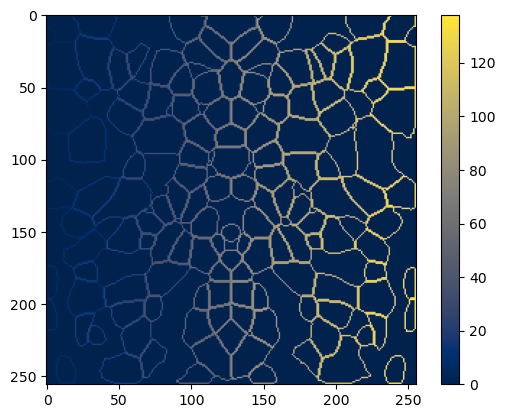

In [66]:
import matplotlib.pyplot as plt

# Assuming 'image' is your 2D numpy array
# Create a color map
cmap = plt.cm.get_cmap('cividis')

# Plot the image with the colormap
plt.imshow(image, cmap=cmap)
plt.colorbar()
plt.show()

(-0.5, 255.5, 255.5, -0.5)

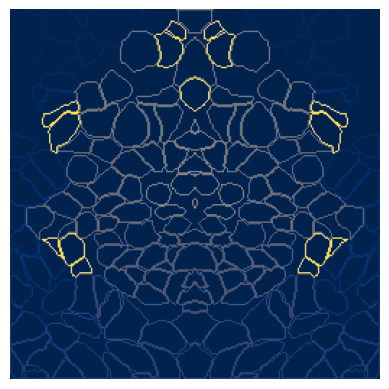

In [55]:
# Vizualize the actual outlines by plotting the seg.npy file
seg = np.load('augmented/test/left_mirrored_breast_vectra_0_seg.npy', allow_pickle=True).item()
masks = seg['outlines'].squeeze()
plt.imshow(masks, cmap=cmap)
plt.axis('off')

In [ ]:
nr_objects

In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage import label

# Assuming 'outlines' is your 2D numpy array
labeled, nr_objects = label(outlines)

# Create a color map
cmap = plt.cm.get_cmap('nipy_spectral', nr_objects)

# Plot the labeled outlines
plt.imshow(labeled, cmap=cmap)
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(outline_arr)
plt.axis('off')  # Optional: Turn off the axis labels
plt.show()

In [ ]:
import numpy as np

# Convert masks to numpy array
masks_array = masks[0]

# Generate outlines from masks
outlines = utils.masks_to_outlines(masks_array)


In [ ]:
import numpy as np
# Assuming "outlines" is a numpy array
np.set_printoptions(threshold=np.inf)
print(outlines)


In [ ]:
import matplotlib.pyplot as plt

# Assuming you have an RGB image stored in the variable 'img'
plt.imshow(outlines)
plt.axis('off')  # Optional: Turn off the axis labels
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Assuming masks is a list of numpy arrays
for mask in masks:
    plt.imshow(mask, cmap='gray')
    plt.show()

In [ ]:
files[0]

In [ ]:
f = files[0]
plt.figure(figsize=(12,4), dpi=300)
plt.imshow(io.imread(os.path.splitext(f)[0] + '_cp_output.png'))
plt.axis('off')